## Base Imports and Tensorflow

In [1]:
import pandas as pd
import sys

%matplotlib inline

## Setup azure workspace for Data & Labels

In [2]:
#import for Azure data
from azureml.core import Dataset, Datastore, Workspace, Experiment, ComputeTarget
# import azureml.contrib.dataset
# from azureml.contrib.dataset import FileHandlingOption, LabeledDatasetTask
from azureml.core.authentication import InteractiveLoginAuthentication
import os
from pathlib import Path, PurePosixPath, PureWindowsPath

In [3]:
df_lab = pd.read_csv('../datasets/animals/labels.csv')
df_lab.head()

,FilePath,Label
0,cats/cats_00072.jpg,cat
1,cats/cats_00073.jpg,cat
2,cats/cats_00074.jpg,cat
3,cats/cats_00075.jpg,cat
4,cats/cats_00076.jpg,cat


In [4]:
# Set data directory to where images are
data_dir = '../datasets/animals'

In [5]:
# get file paths and labels from label df
file_paths_and_labels_df = df_lab

In [6]:
file_paths_and_labels_df.head()

,FilePath,Label
0,cats/cats_00072.jpg,cat
1,cats/cats_00073.jpg,cat
2,cats/cats_00074.jpg,cat
3,cats/cats_00075.jpg,cat
4,cats/cats_00076.jpg,cat


In [7]:
file_paths_and_labels_df.shape

(2850, 2)

In [8]:
# TODO SET RANDOM SEEDS

In [9]:
# Model Params

# Image height & width
img_height = 128
img_width = 128
img_depth = 3

IMG_SHAPE = (img_height, img_width, img_depth)


# initialize learning rate, batch size, and number of epochs
INIT_LR =  0.001
BATCH_SIZE = 32
NUM_EPOCHS = 2

# initialize the label names if needed
num_classes = 3


## Load Images

In [10]:
sys.path.insert(0, './helpers')

In [11]:
from image_loader import Train_generator



In [12]:
gen = Train_generator(img_height,
                      img_width,BATCH_SIZE,
                      data_dir,
                      file_paths_and_labels_df)

Found 2280 validated image filenames belonging to 3 classes.
Found 570 validated image filenames belonging to 3 classes.


In [13]:
# gen.image_check()

## Create Model

In [14]:
from model import Resnet

2.0.0


In [15]:
res = Resnet(num_classes,INIT_LR,NUM_EPOCHS,IMG_SHAPE)

[INFO] Initialize optimizer


In [16]:
train_data = gen.train_generator
val_data = gen.validation_generator

In [17]:
res.train(BATCH_SIZE,
              NUM_EPOCHS,
              train_data,
              val_data)

Epoch 1/2
71/71 [==============================] - 20s 287ms/step - loss: 0.5886 - accuracy: 0.7420 - val_loss: 0.4073 - val_accuracy: 0.8621
Epoch 2/2
71/71 [==============================] - 18s 255ms/step - loss: 0.1644 - accuracy: 0.9377 - val_loss: 0.3435 - val_accuracy: 0.8934


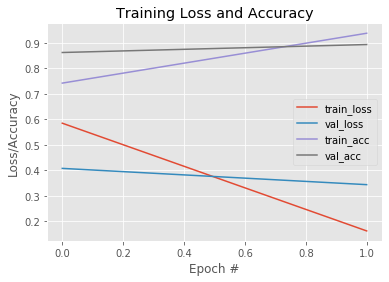

In [18]:
res.history(NUM_EPOCHS)

In [19]:
# model.save('outputs/weights.hdf5')

In [20]:
#plt.savefig('foo.png')

In [21]:
import shap

In [22]:
model = res.model